# Data Analysis





## Import libraries

In [28]:
import pandas as pd


## Read data

In [29]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud


The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


^C


creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip creditcardfraud.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
credidcard_fraud_df = pd.read_csv('creditcardfraud/creditcard.csv')


## General stats about the data

* Attributes
* df.describe()


### Data Cleaning

In [34]:
credidcard_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [35]:
# cheack for dublicates

credidcard_fraud_df.drop_duplicates()
credidcard_fraud_df.info()

# No duplicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Find what distribution each Feature follows

In [39]:
! python -m pip install scipy

You should consider upgrading via the 'c:\Users\EfaOsk\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [40]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# Stolen Code :o Then modified

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford',
                 'burr','burr12','cauchy','chi','chi2','cosine','dgamma',
                 'dweibull','erlang','expon','exponnorm','exponweib','exponpow',
                 'f','fatiguelife','fisk','foldcauchy','foldnorm','genlogistic',
                 'genpareto','gennorm','genexpon','genextreme','gausshyper',
                 'gamma','gengamma','genhalflogistic','gilbrat','gompertz',
                 'gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm',
                 'halfgennorm','hypsecant','invgamma','invgauss','invweibull',
                 'johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l',
                 'logistic','loggamma','loglaplace','lognorm','lomax','maxwell',
                 'mielke','nakagami','ncx2','ncf','nct','norm','pareto',
                 'pearson3','powerlaw','powerlognorm','powernorm','rdist',
                 'reciprocal','rayleigh','rice','recipinvgauss','semicircular',
                 't','triang','truncexpon','truncnorm','tukeylambda','uniform',
                 'vonmises','vonmises_line','wald','weibull_min','weibull_max']


def find_a_fitting_dist(data):
    '''Finds a fitting distribution for data'''
    results = list()
    for i in list_of_dists:
        dist = getattr(stats, i)
        param = dist.fit(data)
        a = stats.kstest(data, i, args=param)
        results.append((i,a[0],a[1]))
  
    results.sort(key=lambda x:float(x[2]), reverse=True)

    # return (<name of dist>, args*)
    return results[0][0], getattr(stats, results[0][0]).fit(data)


def plot_data_w_dist(data, dist, title = "Title", n_bins=40):
    plt.title(title, fontsize=22, fontweight="bold")
    x= np.linspace(min(data), max(data))
    plt.hist(data, bins = n_bins, density=True)
    eval('plt.plot(x, stats.{}.pdf(x, {}))'.format(str(dist[0]), 
        ', '.join(list([str(x) for x in dist[1]]))))



ModuleNotFoundError: No module named 'matplotlib'

In [32]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')
# TODO: Remove ? or disable

# For each feature plot the data with the fitting curve

for i , f_id in enumerate(credidcard_fraud_df.columns ):
    if i>1: pass
    # ToDo add p-value to title
    plot_data_w_dist(credidcard_fraud_df[f_id], find_a_fitting_dist(credidcard_fraud_df[f_id]), f_id, n_bins=100)


NameError: name 'plot_data_w_dist' is not defined

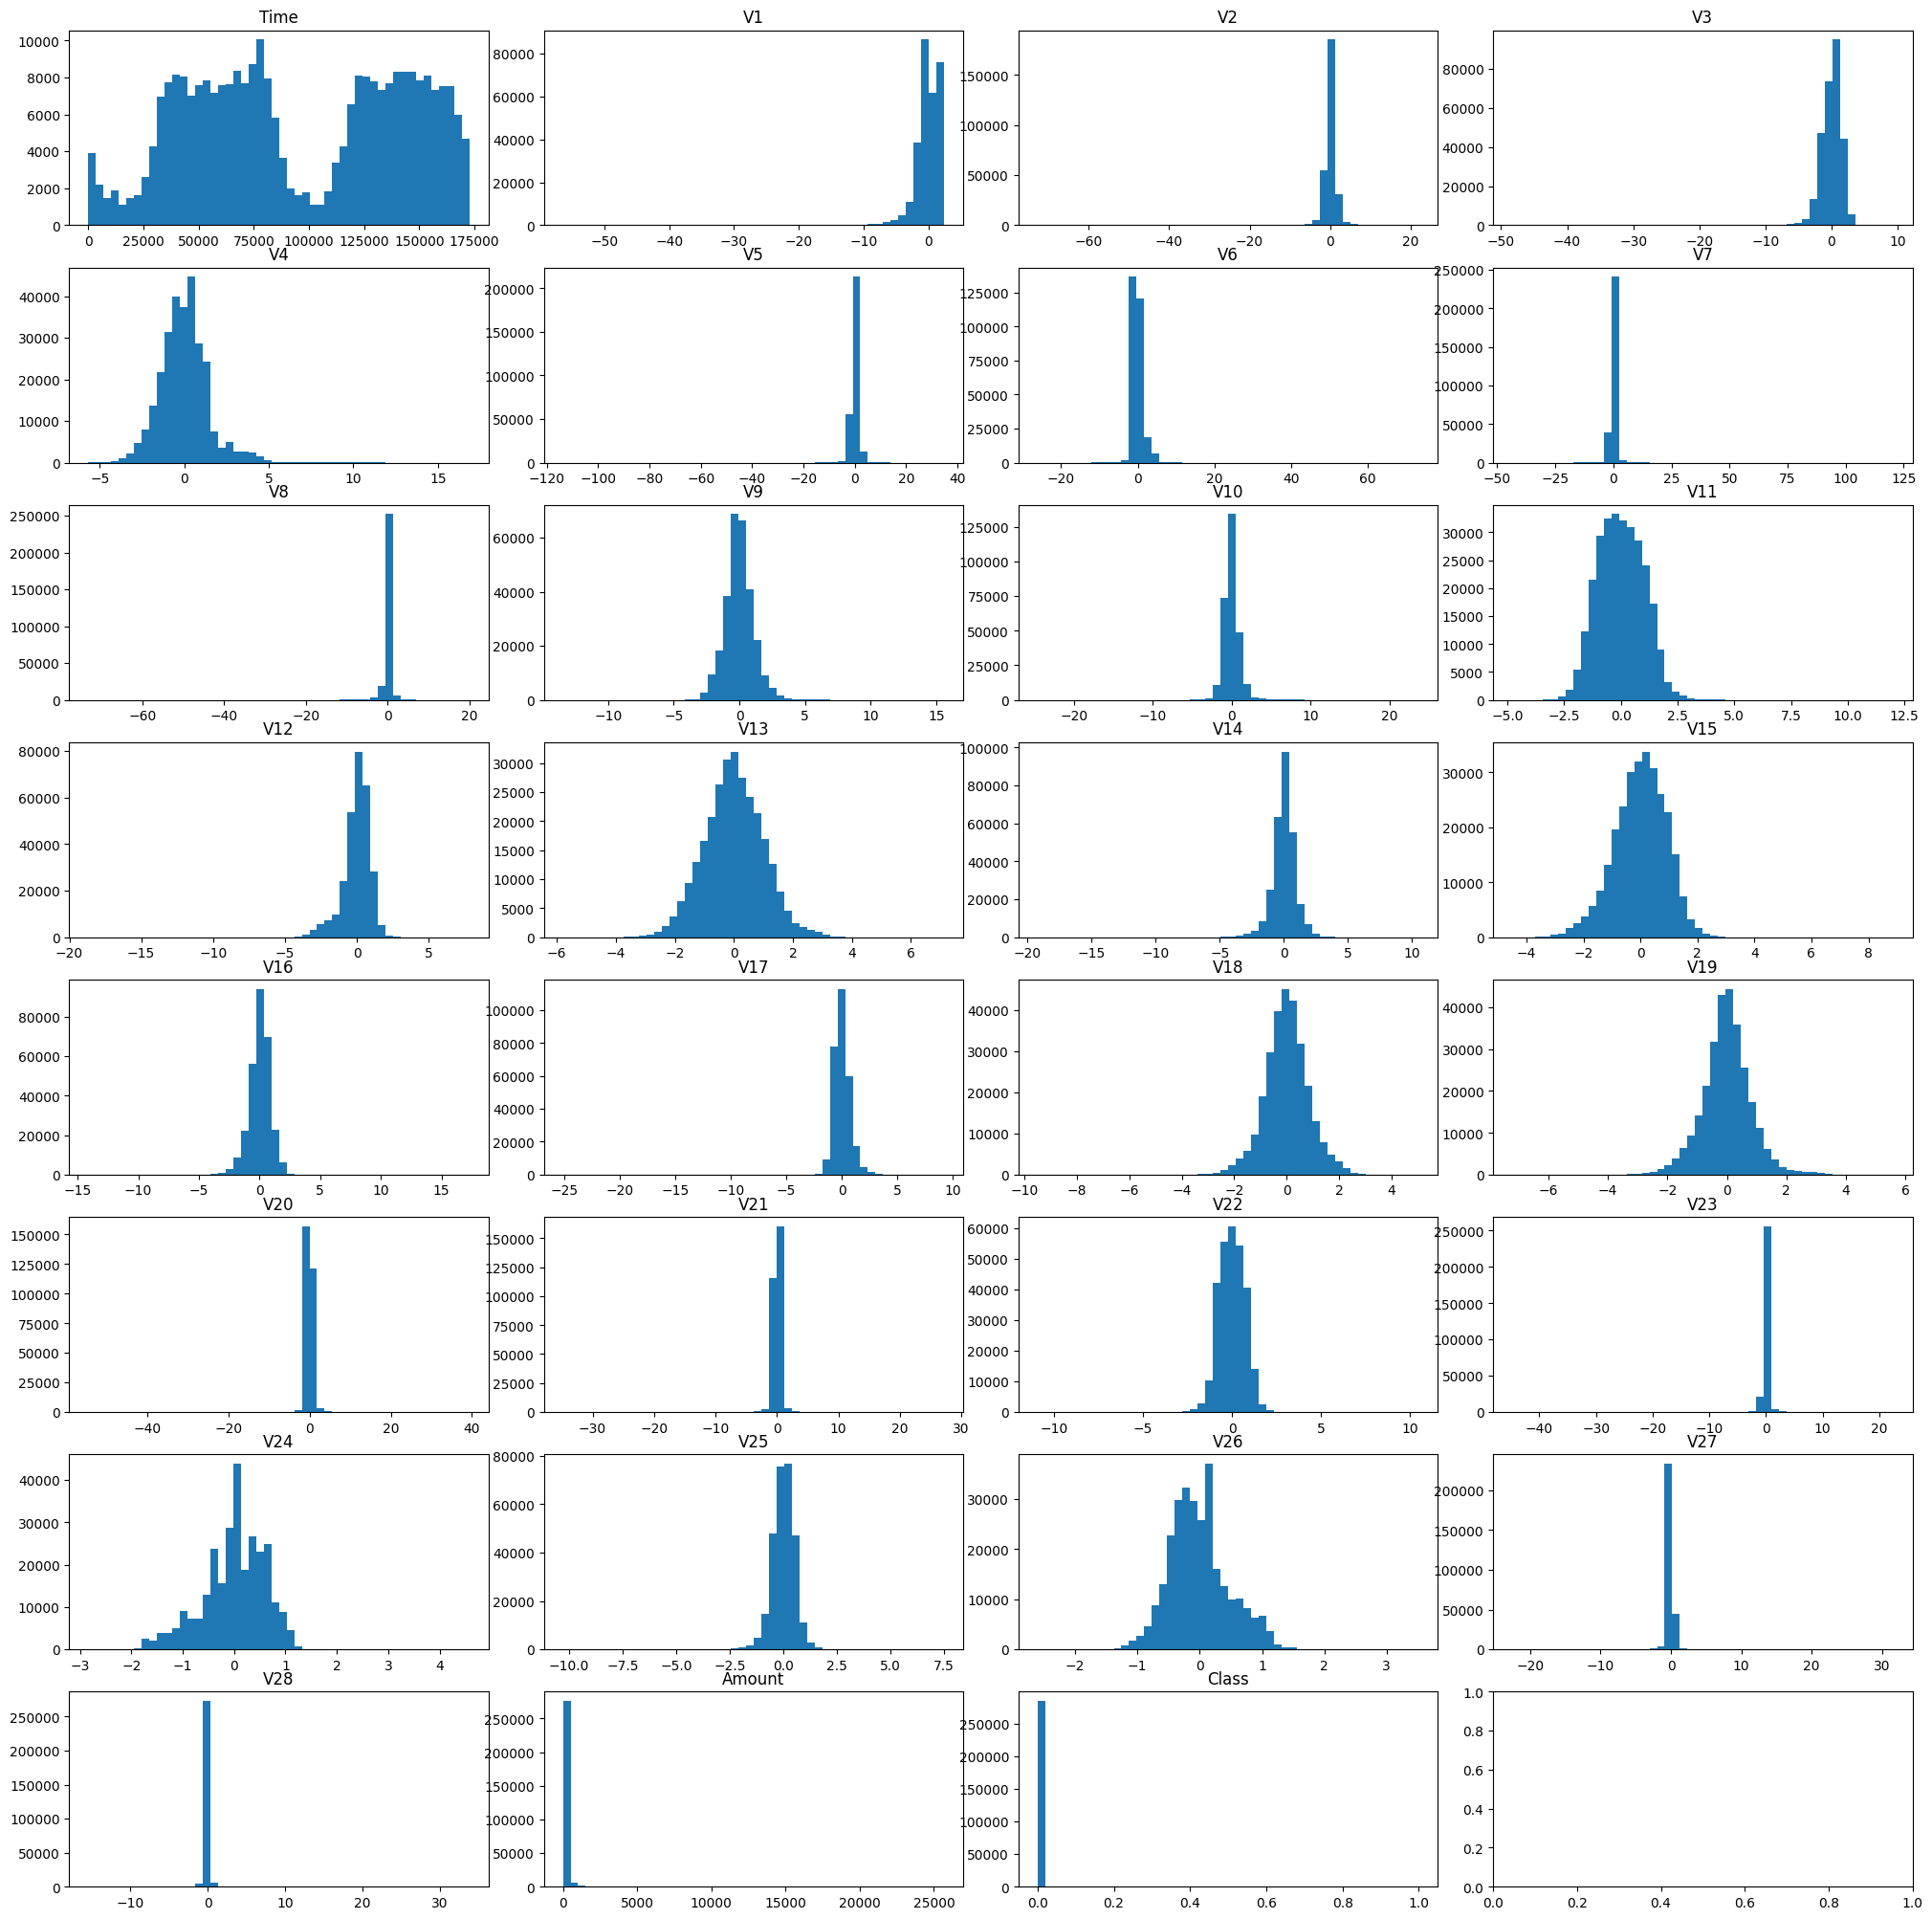

In [48]:
# plot distribution of all features

fig, axs = plt.subplots(8, 4, figsize=(20, 20))
fig.tight_layout()
for i , f_id in enumerate(credidcard_fraud_df.columns ):
    axs[i//4][i%4].hist(credidcard_fraud_df[f_id], bins=50)
    axs[i//4][i%4].set_title(f_id)

### Clean and wrangle

### Do some useful stuff